# Red neuronal desde 0

## Imports

In [1]:
import numpy as np
#Serelizar y deserializar objetos Python
import pickle
#Dataset 
from sklearn.datasets import fetch_openml
#Paths
import os.path

## Definición de Framework

### Funciones

In [2]:
"""
Definición de funciones de activación, derivadas 
"""
def sigmoid(x):
    # Añadir estabilidad numérica
    x = np.clip(x, -500, 500)  # Evitar overflow
    return 1.0/(1.0+np.exp(-x))

def sigmoid_grad(sigmoid):
    """
    NOTA: Observe que recibe el sigmoid ya calculado
    """
    return np.clip(sigmoid * (1.0 - sigmoid), 0, 1)  # Asegurar que el resultado esté entre 0 y 1

def relu(x):
    return x * (x > 0)

def relu_grad(x):
    return 1.0 * (x > 0)

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def logloss (x, y):
    probs = softmax(x)
    return probs, y * np.log(probs)* -1

def batch_hits(x, y):
    """ Aciertos """
    return np.sum(np.argmax(x, axis=1) == y)

### Base

In [3]:
class base():
    """ Codigo de clase base para crear una capa
        Cada capa debe de implementar su método de forward y backward
        Además debe de almacenar el calculo de self.grads
    """
    def __init__(self, input_size, output_size, use_xavier = True) -> None:
        self.input_size = input_size
        self.output_size = output_size
        if use_xavier:
            self._xavier_initialization() 
        else:
            self._initialization_uniform()
        self.o = np.zeros(output_size)
        self.x = None # Asignado durante el forward

    def _initialization_uniform(self):
        self.W = np.random.randn(self.input_size, self.output_size)
        self.b = np.random.randn(self.output_size)
        
    def _xavier_initialization(self):
        """
        Understanding the difficulty of training deep feedforward neural networks
        Xavier Glorot, Yoshua Bengio
        """
        self.W = np.random.randn(self.input_size, self.output_size) / np.sqrt(self.input_size)
        self.b = np.random.randn(self.output_size)
    
    def forward(self, x):
        pass
    
    def backward(self, prev):
        pass

    def update(self, lr):
        # Corregir las dimensiones para la actualización de pesos
        self.W -= lr * np.dot(self.x.T, self.delta)
        self.b -= lr * np.mean(self.delta, axis=0)

### Loss Layer

In [4]:
class loss_layer(base):
    """
    Capa de perdida para regresión:
    Usa activación lineal y error cuadrático medio
    """
    def __init__(self, input_size, output_size) -> None:
        super().__init__(input_size, output_size)
        self.delta = np.zeros((output_size, input_size))

    def forward(self, x):
        self.x = x
        self.linear = np.dot(x, self.W) + self.b
        self.output = self.linear  # Activación lineal para regresión
        return self.output
    
    def backward(self, y):
        # Calcular el gradiente de la pérdida
        batch_size = self.x.shape[0]
        self.delta = 2 * (self.output - y) / batch_size
        return self.delta

    def loss(self, y):
        # Error cuadrático medio
        return np.mean((self.output - y) ** 2)

### Dense Layer

In [5]:
class dense(base):
    """
    Dense o FullyConnected 
    Recibe tamaños de entrada y salida, mas la funcion de activacion y su derivada.
    """
    def __init__(self, input_size, output_size, func_acivation, func_acivation_grad):
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))
        self.func_activation = func_acivation
        self.func_acivation_grad = func_acivation_grad
        
    def forward(self, x):
        self.x = x
        self.linear = np.dot(x, self.W) + self.b
        self.o = self.func_activation(self.linear)
        return self.o 

    def backward(self, prev):
        # Calcular el gradiente local
        self.delta = prev * self.func_acivation_grad(self.linear)
        
        # Calcular gradientes para W y b
        self.W_grad = np.dot(self.x.T, self.delta)
        self.b_grad = np.sum(self.delta, axis=0)
        
        # Propagar el gradiente hacia atrás
        return np.dot(self.delta, self.W.T)

## Definición de Modelo

In [6]:
class model():
    """
    Representa todo el modelo, el tamaño de entrada  y salida de la red,
    una lista con el tamaño que debe llevar cada capa oculpa, y las funciones de activación
    y gradiente que van a tener todas las capas ocultas
    NOTA: Todas las capas ocultas tienen la misma funcion. 
    """
    def __init__(self, input_size, output_size, hidden_shapes, func_acti, func_acti_grad):
        assert(len(hidden_shapes) > 0), "Debe tener al menos 1 capa oculta"
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.hidden_amount = len(self.hidden_shapes)
        self.hidden_layers = [] #Bucket de capas ocultas
        self._populate_layers(func_acti, func_acti_grad)

    def _populate_layers(self, func_acti, func_acti_grad):
        """
        Crea todas las capas ocultas de acuerdo al input size y hidden_shapes
        Agrega una capa final de perdida
        """
        input_size = self.input_size
        for i in range(0, self.hidden_amount):
            new_dense_layer = dense(input_size, self.hidden_shapes[i], func_acti, func_acti_grad)
            self.hidden_layers.append(new_dense_layer)
            input_size = self.hidden_shapes[i]

        self.loss_layer = loss_layer(input_size, self.output_size)

    def forward(self,x, y):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades y la perdida"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        self.o = self.loss_layer.forward(data)
        loss = self.loss_layer.loss(y)
        
        return self.o, loss
    
    def predict(self, x):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        return self.loss_layer.forward(data)
    
    def backward(self, y, o):
        #Calcula la gradiente de la perdida con respecto a la etiqueta Y
        self.loss_layer.backward(y)
        prev = self.loss_layer

        for i in reversed(range(self.hidden_amount)):
            #Propaga la capa para el calculo de gradientes en cada una
            self.hidden_layers[i].backward(prev)
            prev = self.hidden_layers[i]

    def update(self, lr):
        """ Ejecuta la actualización de parametros para cada capa
            despues de actualizar los gradientes
        """
        for i in range(self.hidden_amount):
            self.hidden_layers[i].update(lr)
        self.loss_layer.update(lr)

## Dataset

In [7]:
""" Descarga el dataset de sklearns """
from sklearn.datasets import fetch_california_housing
filename = 'house_prices.ds'
if not os.path.exists(filename):
    housing = fetch_california_housing()
    outfile = open(filename,'wb')
    pickle.dump(housing, outfile)
    outfile.close()

In [8]:
def _shuffle(x, y):
    assert(len(x) == len(y)), "Make sure data and labels have the same lenght!"
    rand_indexes = np.random.permutation(len(x))
    return x[rand_indexes], y[rand_indexes]

#represents a dataset, useful for val dataset, train dataset and test dataset.
class dataset():
    def __init__(self, x, y, batch_size):
        #assert(len(y) % batch_size == 0), "Make sure batch size divides number of items perfectly!"
        self.compl_x = x[:]
        self.compl_y = y[:]
        self.batch_size = batch_size
        self.reset()
        self.size = len(self.compl_y)

    def shapes(self):
        return ( self.compl_x.shape, self.compl_y.shape )

    def view(self):
        print(self.compl_x, self.compl_y)

    #iterate over the dataset
    def next(self):
        if self.left_items < self.batch_size:
            x = self.x[self.current:]
            y = self.y[self.current:]
            self.current += len(self.x)
            self.left_items = 0
            return x, y
        else:
            x = self.x[self.current:self.current+self.batch_size]
            y = self.y[self.current:self.current+self.batch_size]
            self.current += self.batch_size
            self.left_items -= self.batch_size
            return x, y

    def iter_done(self):
        return self.left_items == 0

    def reset(self):
        self.x = self.compl_x[:]
        self.y = self.compl_y[:]
        self.x, self.y = _shuffle(self.x, self.y)
        self.current = 0
        self.left_items = len(self.compl_y)

#splits a complete dataset into 3 subsets for train, val and test, by percentage
class dataset_splitter():
    def __init__(self, x, y, batch_size, perc_train=0.8, perc_val=0.2):
        self.x = x
        self.y = y
        self.split(batch_size, perc_train, perc_val)

    def _split_by_limits(self, batch_size, train_limit, val_limit):
        #Crea los dataset de entrenamiento, validación y testing
        self.ds_train = dataset(self.x[:train_limit], self.y[:train_limit], batch_size)
        self.ds_train.reset()
        self.ds_val = dataset(self.x[train_limit:val_limit], self.y[train_limit:val_limit], batch_size)
        self.ds_val.reset()
        self.ds_test = dataset(self.x[val_limit:], self.y[val_limit:], batch_size)
        self.ds_test.reset()

    def split(self, batch_size, perc_train, perc_val):
        self.x, self.y = _shuffle(self.x, self.y)
        n = len(self.x)
        train_limit = int(n * perc_train)
        temp = int(train_limit * (1.0 - perc_val))
        val_limit = train_limit - temp
        train_limit = temp
        #print(n, train_limit, val_limit)
        self._split_by_limits(batch_size, train_limit, train_limit+val_limit)
        print(self.ds_train.shapes(), self.ds_val.shapes(), self.ds_test.shapes())
        return self.ds_train, self.ds_val, self.ds_test

## Hyperparameters

In [9]:
#hyperparameters
dataset_path = r"house_prices.ds"
batch_size = 32
validate_every_no_of_batches = 20
epochs = 20
input_size = 37
output_size = 1
hidden_shapes = [16]  # Solo una capa oculta pequeña
lr = 0.001
output_log = r"house_prices_log.txt"
with open(dataset_path, "rb") as input_file:
    #Carga el MNIST desde archivo
    housing = pickle.load(input_file)
    print("Tipo housing data: ", type(housing.data))
    print("Forma de housing data: ", housing.data.shape)
    x = housing.data.select_dtypes(include=['int64', 'float64']).values

    for col in range(x.shape[1]):
        col_data = x[:, col]
        mean_val = np.nanmean(col_data)
        x[:, col] = np.where(np.isnan(col_data), mean_val, col_data)

    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x = (x - x_mean) / x_std

    y = np.array(housing.target)
    y_mean = np.mean(y)
    y_std = np.std(y)
    y = (y - y_mean) / y_std
    y = y.reshape(-1, 1)

print("Forma de x: ", x.shape)
print("Forma de y: ", y.shape)
data = dataset(x, y, batch_size)
splitter = dataset_splitter(data.compl_x, data.compl_y, batch_size, 0.8, 0.2)
#Obtiene los dataset del splitter
ds_train = splitter.ds_train
ds_val = splitter.ds_val
ds_test = splitter.ds_test

Tipo housing data:  <class 'pandas.core.frame.DataFrame'>
Forma de housing data:  (1460, 80)
Forma de x:  (1460, 37)
Forma de y:  (1460, 1)
((934, 37), (934, 1)) ((234, 37), (234, 1)) ((292, 37), (292, 1))


In [10]:
class ConfigEnum:
    MNIST = range(1)

#factory-like class which produces different configs for each dataset tested
class hyperparams():

    def __init__(self, config_enum=1): #default is iris based on reqs
        
    
        self.batch_size = batch_size
        self.validate_every_no_of_batches = validate_every_no_of_batches
        self.epochs = epochs
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.lr = lr
        self.output_log = output_log
        self.ds_train = ds_train
        self.ds_test = ds_test
        self.ds_val = ds_val

    def split_again(self, perc_train, perc_val):
        self.ds_train, self.ds_val, self.ds_test = self.splitter.split(self.batch_size, perc_train, perc_val)

## Ejecución

In [11]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import csv
import numpy as np


class nnlogger():
    def __init__(self, output_file, header):
        self.csv_file = open(output_file, "w")
        self.writer = csv.writer(self.csv_file, delimiter=',')
        self.writer.writerow( header )

    def write(self, line):
        self.writer.writerow( line )

    def close(self):
        self.csv_file.close()

class historian():

    def __init__(self, figsize=(8,6)):
        self.iter = []
        self.loss = []

    def add(self, iter, loss):
        self.iter += [ iter ]
        self.loss += [ loss ]


class nnplotter():

    @classmethod
    def view(cls, val_history, train_history):
        ax = plt.subplot(2, 1, 1)
        ax.plot(val_history.iter, val_history.loss, 'b--', label="val")
        ax.plot(train_history.iter, train_history.loss, 'r--', label="train")
        plt.ylabel("MSE loss")
        plt.xlabel("iteration")
        ax.legend()

        plt.show()

In [12]:
def train(nn, hp, val_hist, train_hist, logger):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        cur_trained = 0
        while not(hp.ds_train.iter_done()):
            x, y = hp.ds_train.next()
            pred = nn.forward(x, y)
            loss = nn.loss_layer.loss(y)
            cur_trained += len(x)
            train_loss += loss * len(x)  # Acumular la pérdida total correctamente

            grad = nn.loss_layer.backward(y)
            for layer in reversed(nn.hidden_layers):
                grad = layer.backward(grad)

            # Imprimir pesos antes y después de actualizar para debug
            print('Pesos antes:', nn.hidden_layers[0].W[0][:5])
            nn.update(hp.lr)
            print('Pesos después:', nn.hidden_layers[0].W[0][:5])

            if cur_iter % hp.validate_every_no_of_batches == 0:
                if cur_trained > 0:
                    train_loss = float(train_loss) / float(cur_trained)
                else:
                    train_loss = 0
                train_hist.add(cur_iter, train_loss)
                logger.write( (cur_epoch, "Training", cur_iter, train_loss) )
                train_loss = 0
                cur_trained = 0

                val_loss = test(nn, hp.ds_val, True)
                val_hist.add(cur_iter, val_loss)
                logger.write( (cur_epoch, "Val", cur_iter, val_loss) )

            cur_iter+=1
        cur_epoch+=1
        hp.ds_train.reset()
    return val_hist

def test(nn, ds, verbose=False, phase="Validation"):
    ds.reset()
    total_loss = 0
    n_batches = 0
    all_preds = []
    all_reals = []
    while not(ds.iter_done()):
        x, y = ds.next()
        pred, _ = nn.forward(x, y)  # Desempaquetar la tupla

        # Desnormalizar predicciones y valores reales
        pred_denorm = pred * y_std + y_mean
        y_denorm = y * y_std + y_mean

        all_preds.append(pred_denorm)
        all_reals.append(y_denorm)

        total_loss += np.mean((pred_denorm - y_denorm)**2)
        n_batches += 1

        if verbose and n_batches == 1:
            print("\nPrimeras 5 predicciones vs reales:")
            print("Predicciones (normalizadas):", pred[:5].flatten())
            print("Reales (normalizados):", y[:5].flatten())
            print("Predicciones (desnormalizadas):", pred_denorm[:5].flatten())
            print("Reales (desnormalizados):", y_denorm[:5].flatten())
            print("Diferencias:", np.abs(pred_denorm[:5].flatten() - y_denorm[:5].flatten()))

    mean_loss = float(total_loss) / float(n_batches)
    if verbose:
        print(f"\n{phase} Mean Loss: {mean_loss:.4f}")

    # Imprimir TODOS los valores esperados y predichos (desnormalizados)
    all_preds = np.vstack(all_preds).flatten()
    all_reals = np.vstack(all_reals).flatten()
    print(f"\nComparación completa {phase} (real, predicho):")
    for real, pred in zip(all_reals, all_preds):
        print(f"Real: {real:.2f}  |  Predicho: {pred:.2f}")

    return mean_loss

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Usando tus datos ya divididos
X_train = ds_train.compl_x
y_train = ds_train.compl_y
X_val = ds_val.compl_x
y_val = ds_val.compl_y
X_test = ds_test.compl_x
y_test = ds_test.compl_y

# Entrenar modelo de sklearn
reg = LinearRegression()
reg.fit(X_train, y_train)

# Evaluar
train_mse = np.mean((reg.predict(X_train) - y_train) ** 2)
val_mse = np.mean((reg.predict(X_val) - y_val) ** 2)
test_mse = np.mean((reg.predict(X_test) - y_test) ** 2)

print(f"Train MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 0.18922927408091575
Validation MSE: 0.2263468791938094
Test MSE: 0.1830269393876904


Pesos antes: [-0.23608014 -0.17765485 -0.23496328  0.18301548  0.22830962]
Pesos después: [-0.23615275 -0.17761966 -0.23496328  0.18311102  0.22841577]
Pesos antes: [-0.23615275 -0.17761966 -0.23496328  0.18311102  0.22841577]
Pesos después: [-0.23629572 -0.17775642 -0.23498911  0.18315143  0.22840505]
Pesos antes: [-0.23629572 -0.17775642 -0.23498911  0.18315143  0.22840505]
Pesos después: [-0.23635317 -0.17768371 -0.23498911  0.18321113  0.22852629]
Pesos antes: [-0.23635317 -0.17768371 -0.23498911  0.18321113  0.22852629]
Pesos después: [-0.23640561 -0.17766727 -0.23503934  0.18335907  0.22855198]
Pesos antes: [-0.23640561 -0.17766727 -0.23503934  0.18335907  0.22855198]
Pesos después: [-0.23643431 -0.17765805 -0.23501254  0.18347462  0.22866976]
Pesos antes: [-0.23643431 -0.17765805 -0.23501254  0.18347462  0.22866976]
Pesos después: [-0.23643738 -0.17758281 -0.23501281  0.18366937  0.22868323]
Pesos antes: [-0.23643738 -0.17758281 -0.23501281  0.18366937  0.22868323]
Pesos después

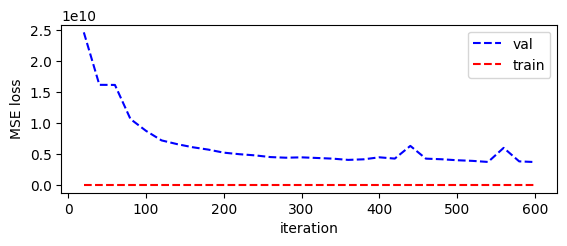

In [14]:
hp = hyperparams(ConfigEnum.MNIST)

#nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, tanh, tanh_grad)
nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, sigmoid, sigmoid_grad)
#nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, relu, relu_grad)
val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Loss") )
train(nn, hp, val_hist, train_hist, logger)
test(nn, hp.ds_test, verbose=True, phase="Test")
nnplotter.view(val_hist, train_hist) #see results on plot
logger.close()

# QUIZ EXTRA
  1. Resolver un problema de regresión lineal utilizando este framework
  2. Utilizar la funcion tanh en lugar de sigmoid para el entrenamiento de las capas ocultas.
  3. Resolver el problema de las variaciones del proceso de entrenamiento del gráfico.

  Domingo 6 de Octubre